In [1]:
# Import Libs
import time
init_time = time.time()

import os
import pickle
import numpy as np
import ROOT

from functions import HistogramFunctions,AuxiliarFunctions,FigureFunctions,FitFunctions,rootnotes

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 20

current_time = time.time()
print 'Time to import libraries: %1.3f seconds'%(current_time-init_time)


Time to import libraries: 25.417 seconds


In [2]:
# Import Libs
import time
init_time = time.time()

import os
import pickle
import numpy as np
import ROOT

from functions import HistogramFunctions,AuxiliarFunctions,FigureFunctions,FitFunctions,rootnotes

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Read Data

from keras.utils import np_utils

init_time = time.time()

from sklearn import datasets

output = "/home/isabella/Workspace/python/PtRelAnalysis/PtRelAnalysis/Results/DataFiles"

# import some data to play with
# load the signal file
signal = np.load(output+"/"+"lvbb125Matrix.npy")[0:45000,:]
trgt_signal = np.ones(signal.shape[0])

# load the backgrounds files
Wbb = np.load(output+"/"+"WbbMatrix.npy")[0:5000,:]
Wbl = np.load(output+"/"+"WblMatrix.npy")[0:5000,:]
Wcc = np.load(output+"/"+"WccMatrix.npy")[0:5000,:]
Wcl = np.load(output+"/"+"WclMatrix.npy")[0:5000,:]
Wll = np.load(output+"/"+"WllMatrix.npy")[0:5000,:]
WW = np.load(output+"/"+"WWMatrix.npy")[0:5000,:]
WZ = np.load(output+"/"+"WZMatrix.npy")[0:5000,:]
ZZ = np.load(output+"/"+"ZZMatrix.npy")[0:5000,:]
TTbar = np.load(output+"/"+"TTbarMatrix.npy")[0:5000,:]

# concatenate all bkg
all_bkg = np.concatenate((Wbb,Wbl,Wcc,Wcl,Wll,WW,WZ,ZZ,TTbar),axis=0) 
all_trgt_bkg = np.zeros(all_bkg.shape[0])

data_colors = ['b','r']
data_labels = ['signal','bkg']

data=np.append(signal,all_bkg,axis=0)
trgt=np.append(trgt_signal,all_trgt_bkg,axis=0)

sparse_trgt = np_utils.to_categorical(trgt)


print sparse_trgt.shape
current_time = time.time()

save_point = "/home/isabella/Workspace/python/PtRelAnalysis/PtRelAnalysis/Results/NN_ENFPC_Results"

(90000, 2)


In [16]:
#Train a Classifier                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks
from keras.utils import np_utils

from sklearn import cross_validation
from sklearn import preprocessing

n_folds = 10
n_inits = 100
norm = 'mapstd'

CVO = cross_validation.StratifiedKFold(trgt,n_folds)
CVO = list(CVO)

classifiers = {}
trn_desc = {}
#SGD parameters

lr=0.001 
#decay=1e-5
decay=lr/100
momentum=0.9


for ifold in range(n_folds):
    train_id, test_id = CVO[ifold]
    
    # normalize data based in train set
    if norm == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(data[train_id,:])
    elif norm == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(data[train_id,:])
    elif norm == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])
        
    norm_data = scaler.transform(data)
    
    best_init = 0
    best_loss = 999
    best_acc  = 0.0
    
    for i_init in range(n_inits):
        print ('Processing: Fold %i of %i Init %i of %i'%(
                ifold+1, n_folds, 
                i_init+1, n_inits))
        model = Sequential()
        model.add(Dense(data.shape[1],
                        input_dim=data.shape[1],
                        init='identity',
                        trainable=False))
        model.add(Activation('linear'))
        model.add(Dense(100, input_dim=data.shape[1], 
                        init='uniform'))
        model.add(Activation('tanh'))
        model.add(Dense(2,
                        init='uniform')) 
        model.add(Activation('tanh'))
        
        sgd = SGD(lr, decay, momentum)
        model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        earlyStopping = callbacks.EarlyStopping(monitor='val_acc', 
                                                patience=25, 
                                                verbose=0, 
                                                mode='auto')
        # Train model
        init_trn_desc = model.fit(norm_data[train_id], 
                                  sparse_trgt[train_id], 
                                  nb_epoch=100, 
                                  batch_size=100,                                callbacks=[earlyStopping], 
                                  verbose=0, 
                                  validation_data=(norm_data[test_id],
                                                   sparse_trgt[test_id]), 
                                  shuffle=True)
        if np.max(init_trn_desc.history['val_acc']) > best_acc:
            best_init = i_init
            best_acc = np.min(init_trn_desc.history['val_acc'])
            classifiers[ifold] = model
            trn_desc[ifold] = init_trn_desc 
            
import sys 
sys.setrecursionlimit(4000)
pickle.dump(classifiers, open(save_point+'/'+'classificadores_ENFPC.pkl',"wb" ),pickle.HIGHEST_PROTOCOL)
pickle.dump(trn_desc, open(save_point+'/'+'trn_desc_ENFPC.pkl',"wb" ),pickle.HIGHEST_PROTOCOL)

Processing: Fold 1 of 10 Init 1 of 100


/home/isabella/.virtualenvs/pt_rel_analysis/lib/python2.7/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(24, trainable=False, kernel_initializer="identity", input_dim=24)`
/home/isabella/.virtualenvs/pt_rel_analysis/lib/python2.7/site-packages/ipykernel_launcher.py:57: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, kernel_initializer="uniform", input_dim=24)`
/home/isabella/.virtualenvs/pt_rel_analysis/lib/python2.7/site-packages/ipykernel_launcher.py:60: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, kernel_initializer="uniform")`


Processing: Fold 1 of 10 Init 2 of 100
Processing: Fold 1 of 10 Init 3 of 100
Processing: Fold 1 of 10 Init 4 of 100
Processing: Fold 1 of 10 Init 5 of 100
Processing: Fold 1 of 10 Init 6 of 100
Processing: Fold 1 of 10 Init 7 of 100
Processing: Fold 1 of 10 Init 8 of 100
Processing: Fold 1 of 10 Init 9 of 100
Processing: Fold 1 of 10 Init 10 of 100
Processing: Fold 1 of 10 Init 11 of 100
Processing: Fold 1 of 10 Init 12 of 100
Processing: Fold 1 of 10 Init 13 of 100
Processing: Fold 1 of 10 Init 14 of 100
Processing: Fold 1 of 10 Init 15 of 100
Processing: Fold 1 of 10 Init 16 of 100
Processing: Fold 1 of 10 Init 17 of 100
Processing: Fold 1 of 10 Init 18 of 100
Processing: Fold 1 of 10 Init 19 of 100
Processing: Fold 1 of 10 Init 20 of 100
Processing: Fold 1 of 10 Init 21 of 100
Processing: Fold 1 of 10 Init 22 of 100
Processing: Fold 1 of 10 Init 23 of 100
Processing: Fold 1 of 10 Init 24 of 100
Processing: Fold 1 of 10 Init 25 of 100
Processing: Fold 1 of 10 Init 26 of 100
Processi

Processing: Fold 3 of 10 Init 8 of 100
Processing: Fold 3 of 10 Init 9 of 100
Processing: Fold 3 of 10 Init 10 of 100
Processing: Fold 3 of 10 Init 11 of 100
Processing: Fold 3 of 10 Init 12 of 100
Processing: Fold 3 of 10 Init 13 of 100
Processing: Fold 3 of 10 Init 14 of 100
Processing: Fold 3 of 10 Init 15 of 100
Processing: Fold 3 of 10 Init 16 of 100
Processing: Fold 3 of 10 Init 17 of 100
Processing: Fold 3 of 10 Init 18 of 100
Processing: Fold 3 of 10 Init 19 of 100
Processing: Fold 3 of 10 Init 20 of 100
Processing: Fold 3 of 10 Init 21 of 100
Processing: Fold 3 of 10 Init 22 of 100
Processing: Fold 3 of 10 Init 23 of 100
Processing: Fold 3 of 10 Init 24 of 100
Processing: Fold 3 of 10 Init 25 of 100
Processing: Fold 3 of 10 Init 26 of 100
Processing: Fold 3 of 10 Init 27 of 100
Processing: Fold 3 of 10 Init 28 of 100
Processing: Fold 3 of 10 Init 29 of 100
Processing: Fold 3 of 10 Init 30 of 100
Processing: Fold 3 of 10 Init 31 of 100
Processing: Fold 3 of 10 Init 32 of 100
Pr

Processing: Fold 5 of 10 Init 14 of 100
Processing: Fold 5 of 10 Init 15 of 100
Processing: Fold 5 of 10 Init 16 of 100
Processing: Fold 5 of 10 Init 17 of 100
Processing: Fold 5 of 10 Init 18 of 100
Processing: Fold 5 of 10 Init 19 of 100
Processing: Fold 5 of 10 Init 20 of 100
Processing: Fold 5 of 10 Init 21 of 100
Processing: Fold 5 of 10 Init 22 of 100
Processing: Fold 5 of 10 Init 23 of 100
Processing: Fold 5 of 10 Init 24 of 100
Processing: Fold 5 of 10 Init 25 of 100
Processing: Fold 5 of 10 Init 26 of 100
Processing: Fold 5 of 10 Init 27 of 100
Processing: Fold 5 of 10 Init 28 of 100
Processing: Fold 5 of 10 Init 29 of 100
Processing: Fold 5 of 10 Init 30 of 100
Processing: Fold 5 of 10 Init 31 of 100
Processing: Fold 5 of 10 Init 32 of 100
Processing: Fold 5 of 10 Init 33 of 100
Processing: Fold 5 of 10 Init 34 of 100
Processing: Fold 5 of 10 Init 35 of 100
Processing: Fold 5 of 10 Init 36 of 100
Processing: Fold 5 of 10 Init 37 of 100
Processing: Fold 5 of 10 Init 38 of 100


Processing: Fold 7 of 10 Init 20 of 100
Processing: Fold 7 of 10 Init 21 of 100
Processing: Fold 7 of 10 Init 22 of 100
Processing: Fold 7 of 10 Init 23 of 100
Processing: Fold 7 of 10 Init 24 of 100
Processing: Fold 7 of 10 Init 25 of 100
Processing: Fold 7 of 10 Init 26 of 100
Processing: Fold 7 of 10 Init 27 of 100
Processing: Fold 7 of 10 Init 28 of 100
Processing: Fold 7 of 10 Init 29 of 100
Processing: Fold 7 of 10 Init 30 of 100
Processing: Fold 7 of 10 Init 31 of 100
Processing: Fold 7 of 10 Init 32 of 100
Processing: Fold 7 of 10 Init 33 of 100
Processing: Fold 7 of 10 Init 34 of 100
Processing: Fold 7 of 10 Init 35 of 100
Processing: Fold 7 of 10 Init 36 of 100
Processing: Fold 7 of 10 Init 37 of 100
Processing: Fold 7 of 10 Init 38 of 100
Processing: Fold 7 of 10 Init 39 of 100
Processing: Fold 7 of 10 Init 40 of 100
Processing: Fold 7 of 10 Init 41 of 100
Processing: Fold 7 of 10 Init 42 of 100
Processing: Fold 7 of 10 Init 43 of 100
Processing: Fold 7 of 10 Init 44 of 100


Processing: Fold 9 of 10 Init 26 of 100
Processing: Fold 9 of 10 Init 27 of 100
Processing: Fold 9 of 10 Init 28 of 100
Processing: Fold 9 of 10 Init 29 of 100
Processing: Fold 9 of 10 Init 30 of 100
Processing: Fold 9 of 10 Init 31 of 100
Processing: Fold 9 of 10 Init 32 of 100
Processing: Fold 9 of 10 Init 33 of 100
Processing: Fold 9 of 10 Init 34 of 100
Processing: Fold 9 of 10 Init 35 of 100
Processing: Fold 9 of 10 Init 36 of 100
Processing: Fold 9 of 10 Init 37 of 100
Processing: Fold 9 of 10 Init 38 of 100
Processing: Fold 9 of 10 Init 39 of 100
Processing: Fold 9 of 10 Init 40 of 100
Processing: Fold 9 of 10 Init 41 of 100
Processing: Fold 9 of 10 Init 42 of 100
Processing: Fold 9 of 10 Init 43 of 100
Processing: Fold 9 of 10 Init 44 of 100
Processing: Fold 9 of 10 Init 45 of 100
Processing: Fold 9 of 10 Init 46 of 100
Processing: Fold 9 of 10 Init 47 of 100
Processing: Fold 9 of 10 Init 48 of 100
Processing: Fold 9 of 10 Init 49 of 100
Processing: Fold 9 of 10 Init 50 of 100


In [35]:
scores

array([[ 0.55411881,  0.58507764],
       [ 0.33191913,  0.6543085 ],
       [-0.25401163,  0.95947939],
       ..., 
       [ 0.4488762 ,  0.81560171],
       [ 0.31841668,  0.75128984],
       [ 0.72674841,  0.36687452]], dtype=float32)

In [38]:
roc_auc_score(sparse_trgt[test_id], scores)

0.81964619753086421

In [41]:
pickle.dump(CVO, open(save_point+'/'+'CVO_tonormalize_ENFPC.pkl',"wb" ),pickle.HIGHEST_PROTOCOL)

CVO

[(array([ 4500,  4501,  4502, ..., 89997, 89998, 89999]),
  array([    0,     1,     2, ..., 49497, 49498, 49499])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  array([ 4500,  4501,  4502, ..., 53997, 53998, 53999])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  array([ 9000,  9001,  9002, ..., 58497, 58498, 58499])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  array([13500, 13501, 13502, ..., 62997, 62998, 62999])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  array([18000, 18001, 18002, ..., 67497, 67498, 67499])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  array([22500, 22501, 22502, ..., 71997, 71998, 71999])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  array([27000, 27001, 27002, ..., 76497, 76498, 76499])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  array([31500, 31501, 31502, ..., 80997, 80998, 80999])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  arra

In [50]:
# use to load the pkl files!
b = pickle.load(open(save_point+'/'+'CVO_tonormalize_ENFPC.pkl', "rb"))
b

[(array([ 4500,  4501,  4502, ..., 89997, 89998, 89999]),
  array([    0,     1,     2, ..., 49497, 49498, 49499])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  array([ 4500,  4501,  4502, ..., 53997, 53998, 53999])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  array([ 9000,  9001,  9002, ..., 58497, 58498, 58499])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  array([13500, 13501, 13502, ..., 62997, 62998, 62999])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  array([18000, 18001, 18002, ..., 67497, 67498, 67499])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  array([22500, 22501, 22502, ..., 71997, 71998, 71999])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  array([27000, 27001, 27002, ..., 76497, 76498, 76499])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  array([31500, 31501, 31502, ..., 80997, 80998, 80999])),
 (array([    0,     1,     2, ..., 89997, 89998, 89999]),
  arra

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score
scores = classifiers[0].predict(norm_data[test_id])
scores.shape
fpr, tpr, thresholds=roc_curve(sparse_trgt[test_id][:,1], scores[:,1])
fpr2, tpr2, thresholds2=roc_curve(sparse_trgt[test_id][:,0], scores[:,0])

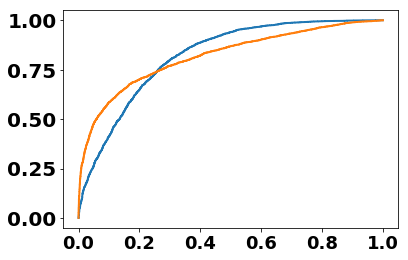

In [32]:
plt.plot(fpr,tpr)
plt.plot(fpr2,tpr2)
plt.show()

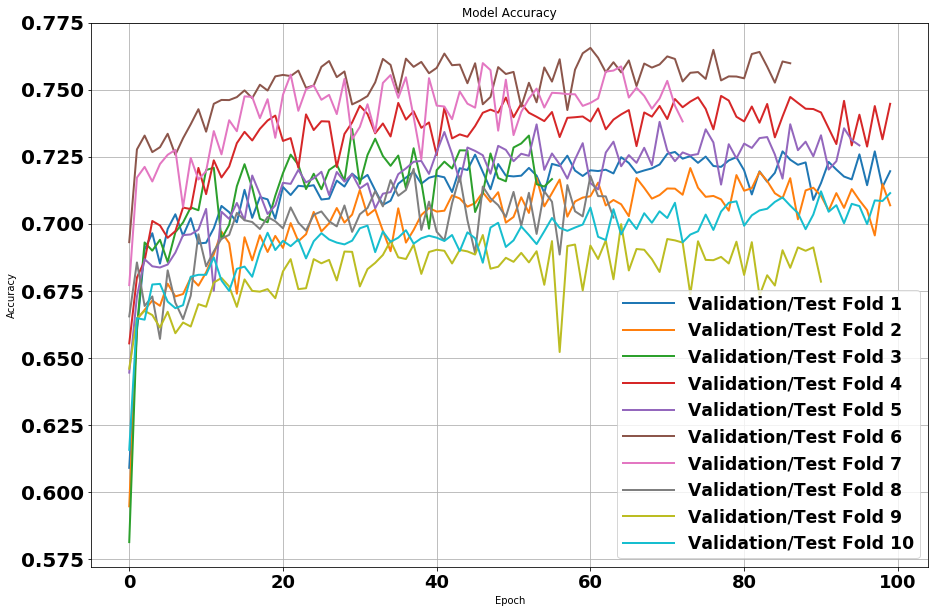

In [17]:
fig, ax = plt.subplots(1,figsize=(15,10))
list_t = []
for i in range(10):
    plt.plot(trn_desc[i].history['val_acc'])
    #plt.plot(T[i].history['val_loss'])
    list_t.append('Validation/Test Fold %.f'%(i+1))
    plt.legend(list_t, loc='best',fontsize = 'xx-large')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.grid()
plt.show()

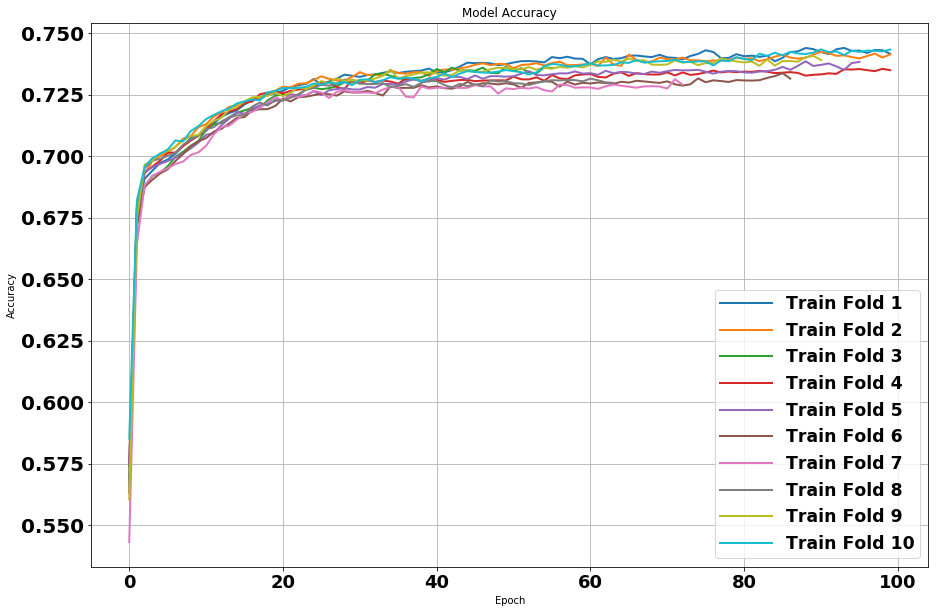

In [18]:
fig, ax = plt.subplots(1,figsize=(15,10))
list_t = []
for i in range(10):
    plt.plot(trn_desc[i].history['acc'])
    #plt.plot(T[i].history['val_loss'])
    list_t.append('Train Fold %.f'%(i+1))
    plt.legend(list_t, loc='best',fontsize = 'xx-large')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.grid()
plt.show()

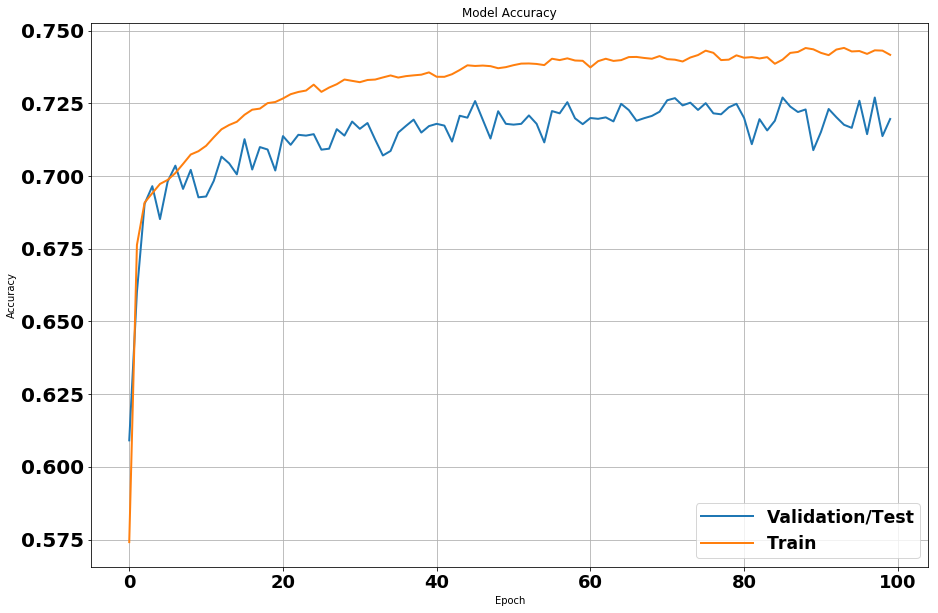

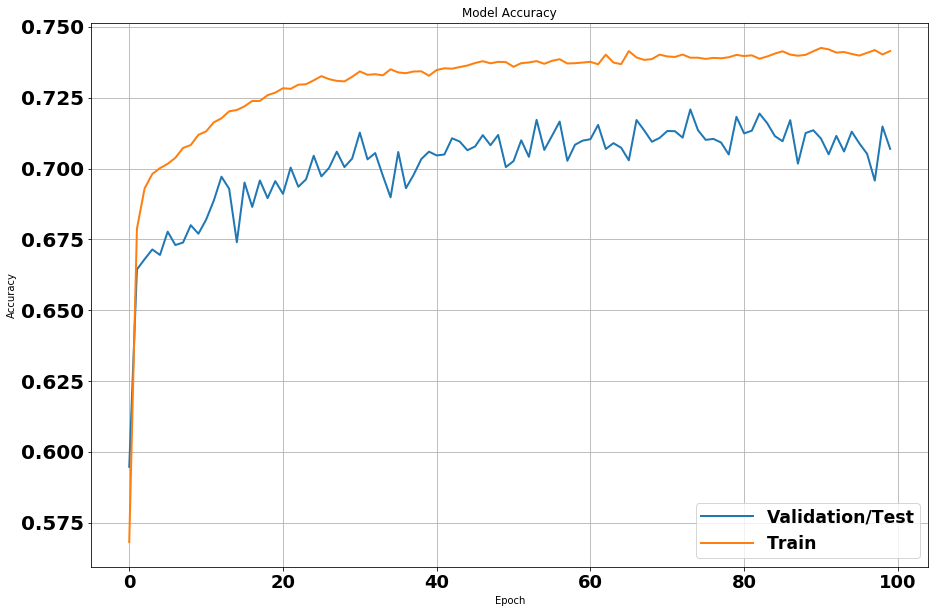

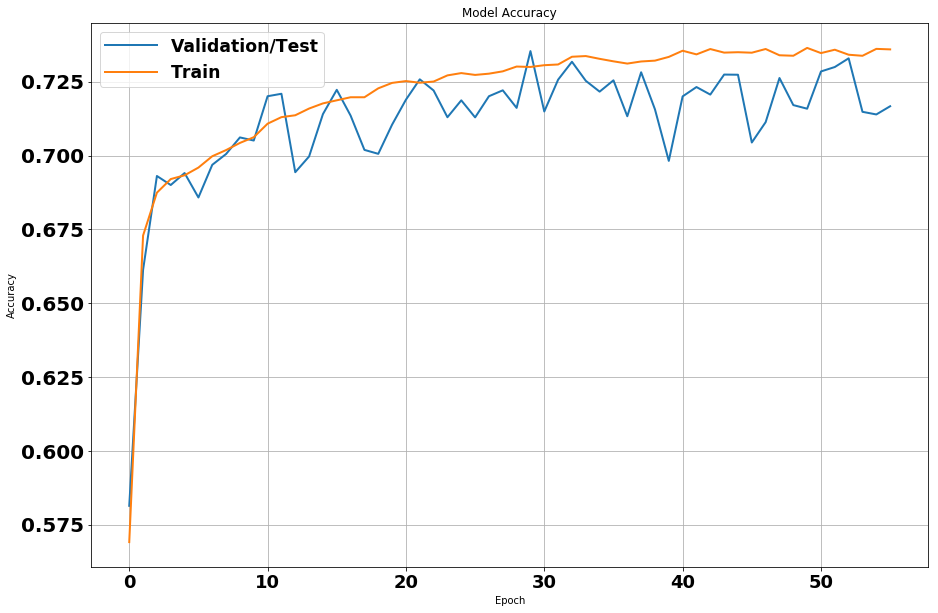

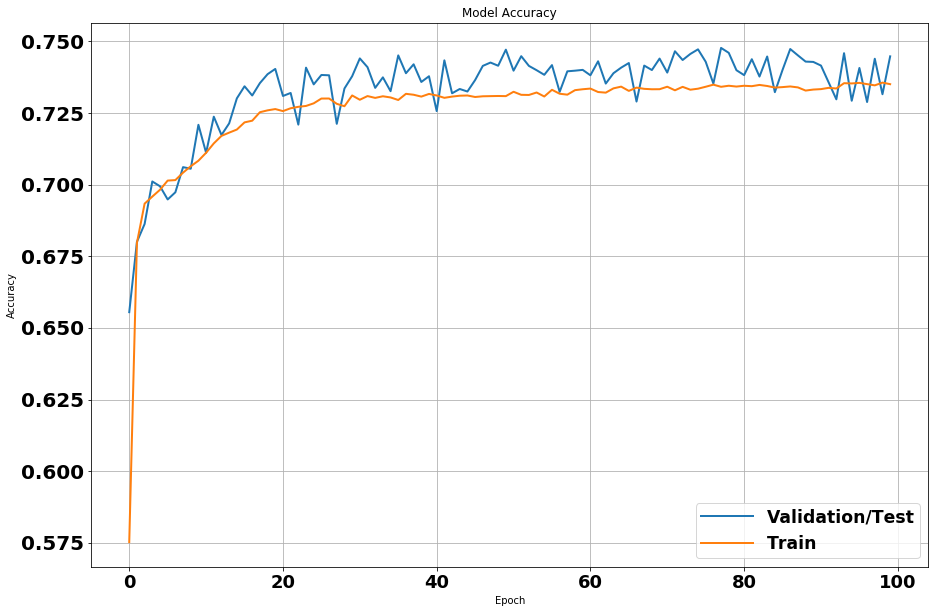

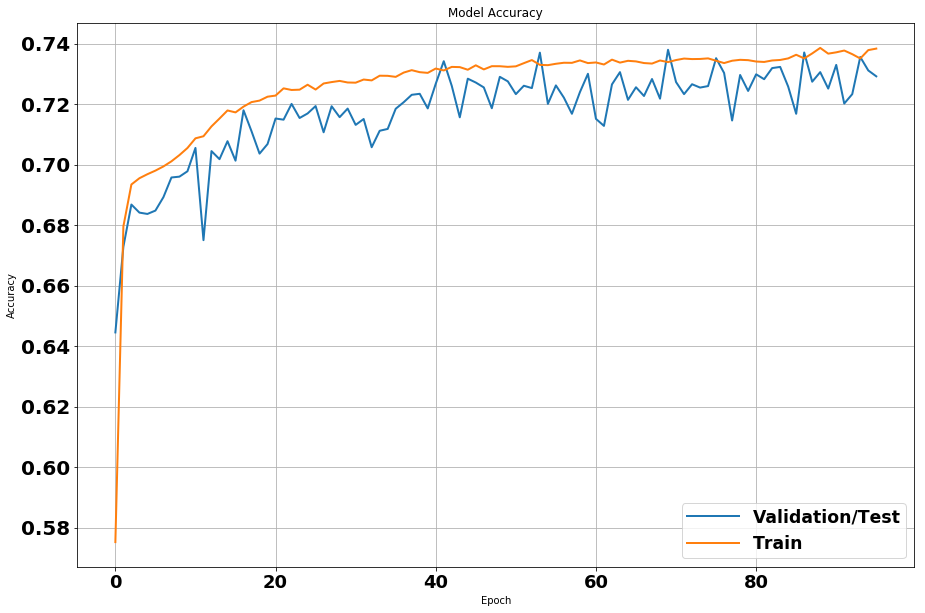

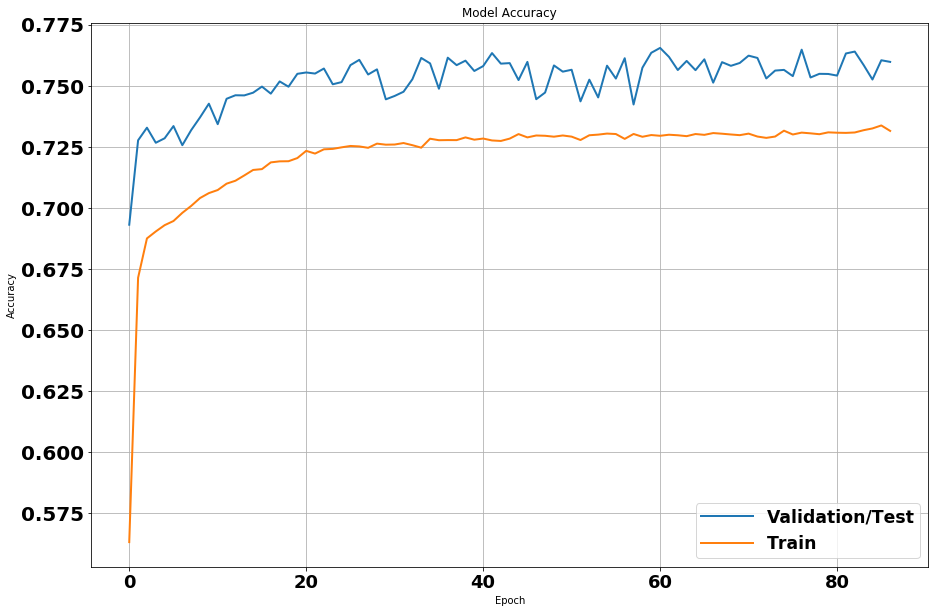

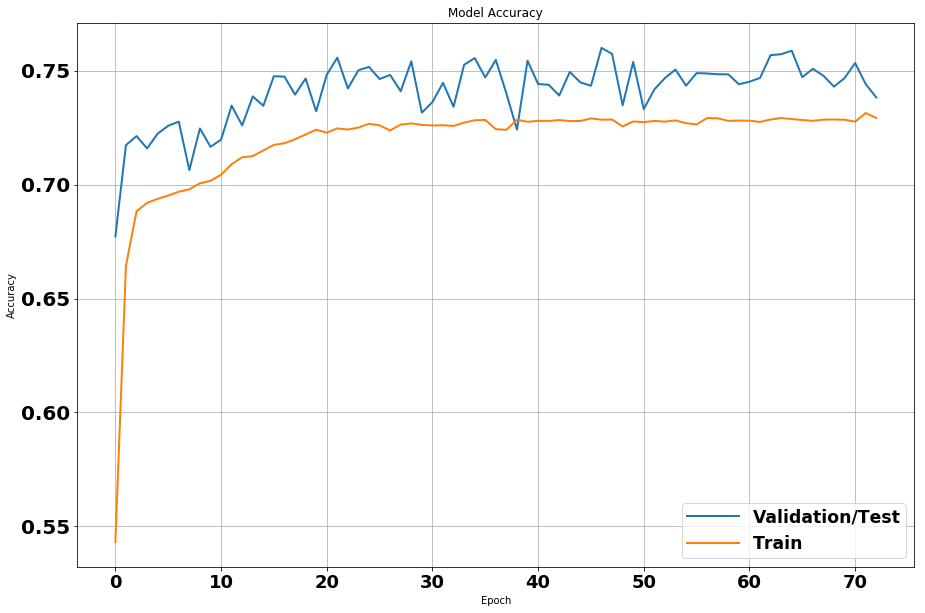

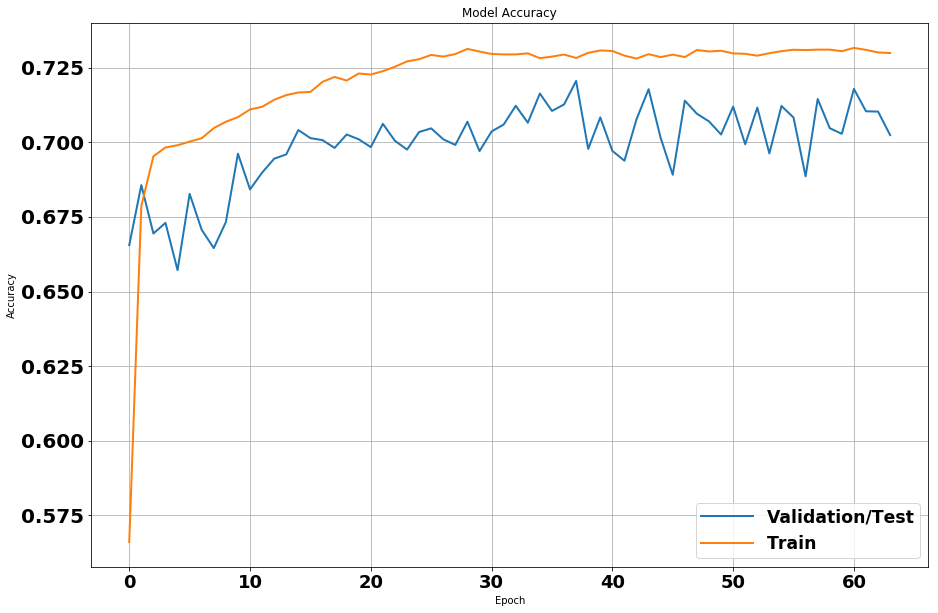

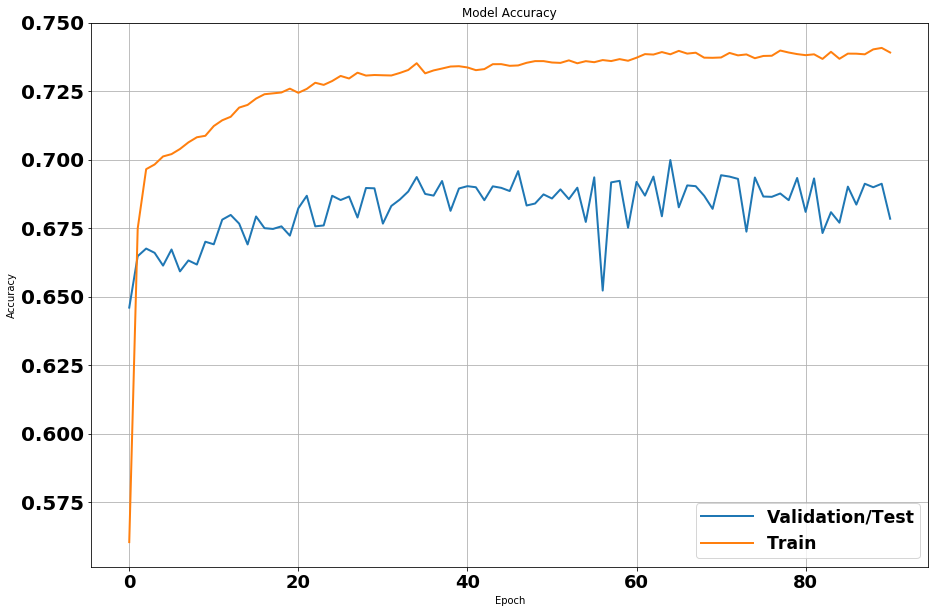

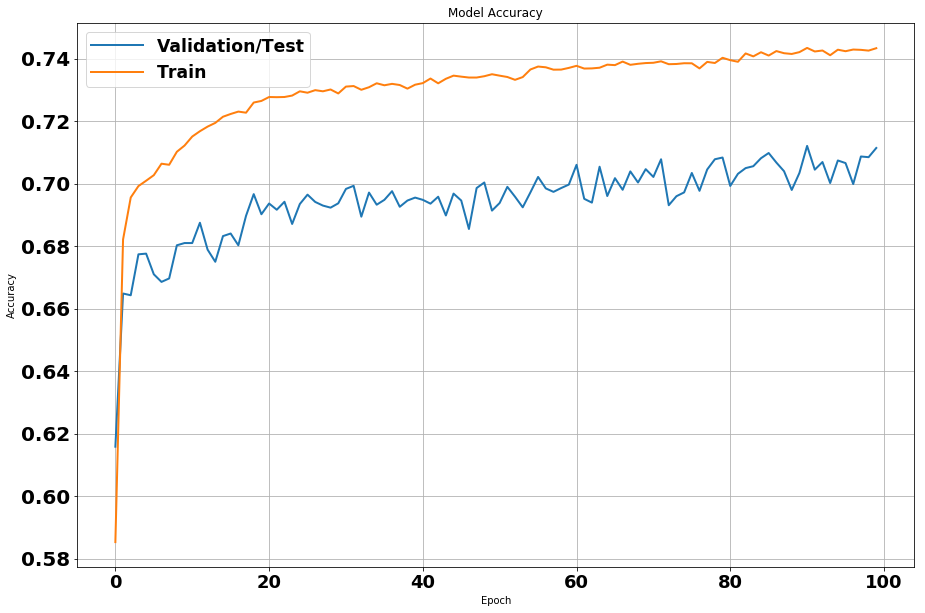

In [20]:

list_t = []
for i in range(10):
    fig, ax = plt.subplots(1,figsize=(15,10))
    plt.plot(trn_desc[i].history['val_acc'],label='Validation/Test')
    plt.plot(trn_desc[i].history['acc'],label='Train')
    #list_t.append('Test Fold %.f'%(i+1))
    plt.legend(loc='best',fontsize = 'xx-large')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.grid()
    plt.show()

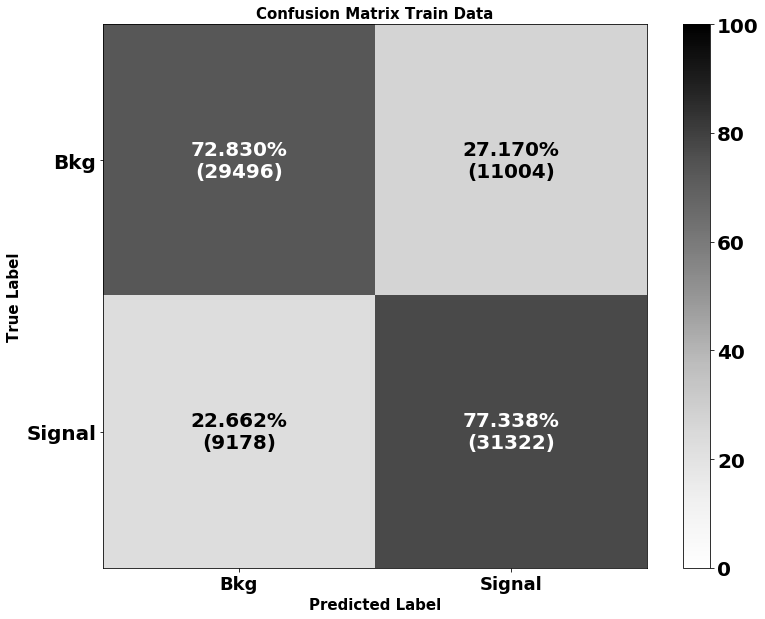

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

data_labels = ['Bkg','Signal']
plt.rcParams['font.weight'] = 'bold'

choose_fold = 0

train_id, test_id = CVO[choose_fold]
# normalize data based in train set
if norm == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(data[train_id,:])
elif norm == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(data[train_id,:])
elif norm == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])
        
norm_data = scaler.transform(data)

output = classifiers[choose_fold].predict(norm_data)
output_class = np.argmax(output,axis=1)

cm = confusion_matrix(trgt[train_id], output_class[train_id])
cm_data = cm
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm

fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape


for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',fontsize=20)
        else:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white',fontsize=20)

ax.set_title('Confusion Matrix Train Data',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(data_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(data_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(data_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)

#save image
fig.savefig(save_point+'/'+'matrix_confusao_encontro_fisica_conjunto_treinamento_com_todos_backgrounds.pdf')

#plt.savefig(path_tosave+'/'+'ConfusionMatrixClassfinal_12clustersTEST_ResultnPtRel.pdf')
#fig.savefig(path_tosave+'/'+'ConfusionMatrixClassfinal_5clustersttbar-4clustersignalTEST_BACKUP.pdf')

In [16]:
from sklearn import metrics

round(metrics.silhouette_score(norm_data[test_id],output_class[test_id]),3)

0.041

In [17]:
from scipy.stats.mstats import gmean


def Acc(output,true_label):
    acc = np.zeros(len(np.unique(output)))
    for i in range(len(np.unique(output))):
        acc[i] = float(np.sum(output[true_label==i]==i))/float((np.sum(true_label==i)))
    return acc

# Calculate the sum-product
def SP(output,true_label):
    
    SP = np.power(np.mean(Acc(output,true_label))*gmean(Acc(output,true_label)),0.5)
    
    return SP

In [18]:
round(metrics.accuracy_score(y_pred=output_class[test_id],y_true=trgt[test_id]),3)

0.677

(90000,)


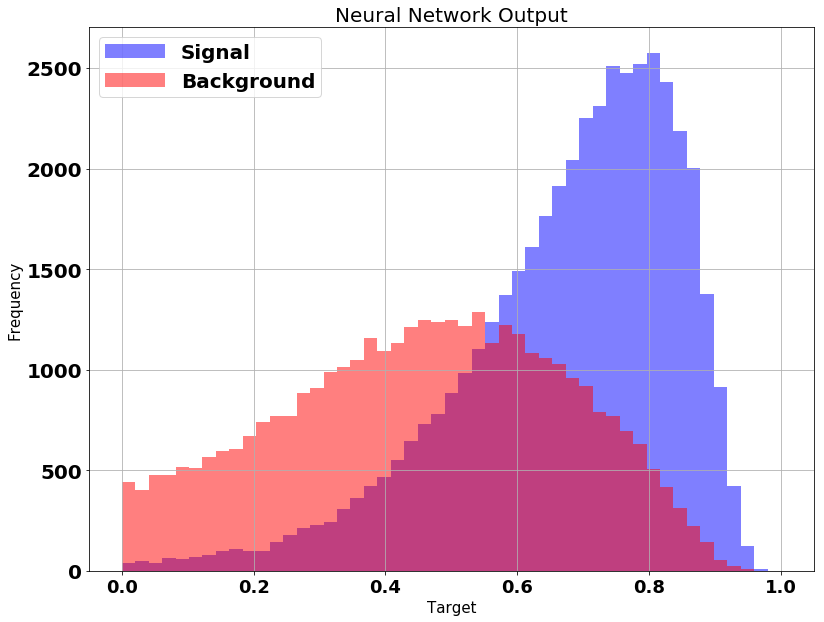

In [23]:
# analyse train process - output distribution
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#save_point = "/home/isabella/Workspace/python/PtRelAnalysis/PtRelAnalysis/Results/"

choose_fold = 0

train_id, test_id = CVO[choose_fold]
# normalize data based in train set
if norm == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(data[train_id,:])
elif norm == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(data[train_id,:])
elif norm == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])
        
norm_data = scaler.transform(data)

output = classifiers[choose_fold].predict(norm_data)
output_class = np.argmax(output,axis=1)

my_bins = np.linspace(0,1, 50)
print output_class.shape
fig = plt.figure(figsize=(13,10))
plt.hist(output[trgt==1,1],bins=my_bins,color='b',alpha=0.5,label='Signal')
plt.hist(output[trgt==0,1],bins=my_bins,color='r',alpha=0.5,label='Background')
plt.title('Neural Network Output',fontsize=20)
plt.xlabel("Target",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.legend(fontsize=20,loc='upper left')
plt.grid()

#save image
plt.savefig(save_point+'/'+'output_rede_neural_encontro_fisica_com_todos_backgrounds.pdf')
plt.show()


#n_rows = trgt.shape[1]
#n_columns = output.shape[1]

#fig, ax = plt.subplots(figsize=(20,20),nrows=n_rows, ncols=n_columns)
#m_bins = np.linspace(-1., 1., 50)


#irow = 0
#icolumn = 0
#for itarget in range(trgt_sparse.shape[1]):
#    for ioutput in range(output.shape[1]):
#        m_pts = output[trgt==itarget,ioutput]
#        n, bins, patches = (ax[irow,icolumn].hist(m_pts,bins=m_bins,
                                                      #fc=iris_colors[itarget],
                                                      #alpha=0.8, normed=1))
#        for tick in ax[irow,icolumn].get_xticklabels():
#            tick.set_rotation(45)
#        ax[irow,icolumn].grid()
    
#        if irow == 0:
#            ax[irow,icolumn].set_title('Output for Neuron %i'%(ioutput+1),
#                                       fontweight='bold',fontsize=15)
#        if icolumn == 0:
#            ax[irow,icolumn].set_ylabel('Class %s'%(iris_labels[itarget]),
#                                        fontweight='bold',fontsize=15)
#        if irow == n_rows-1:
#            ax[irow,icolumn].set_xlabel('Possible Values',
#                                        fontweight='bold',fontsize=15)
    
        
#        if icolumn+1 == n_columns:
#            icolumn = 0
#            irow = irow+1
#        else:
#            icolumn = icolumn+1

In [20]:
norm_signal = scaler.transform(signal)

output_signal = classifiers[choose_fold].predict(norm_signal)
output_signal_class = np.argmax(output_signal,axis=1)

#print 'output_sinal',output_signal

In [14]:
ROOT.gROOT.Reset()
ROOT.gStyle.SetOptStat(0)

In [15]:
import ROOT
ROOT.gROOT.Reset()
ROOT.gStyle.SetOptStat(0)

# for histograms
bins = 60
m_max = 300
m_min = 0

ylabel = "Occurrences"

# Use Colors
list_color = []
list_color.append(ROOT.kRed) # For Signal
list_color.append(ROOT.kGreen+3) # For Bkg
list_color.append(ROOT.kGreen+2) # For Bkg
list_color.append(ROOT.kGreen+1) # For Bkg
list_color.append(ROOT.kGreen-6) # For Bkg
list_color.append(ROOT.kGreen-9) # For Bkg
list_color.append(ROOT.kOrange+0) # For Bkg
list_color.append(ROOT.kGray+3) # For Bkg
list_color.append(ROOT.kGray) # For Bkg
list_color.append(ROOT.kGray+1) # For Bkg

#  Make a list of mass histogram
list_inf_M = []

hist_inf = HistogramFunctions.OneDimHistInfo("Signal Mass ","h_lvbb_M",bins,m_min,m_max,"Invariant Mass",ylabel)
list_inf_M.append(hist_inf)


hist_inf = HistogramFunctions.OneDimHistInfo("Bkg Wbb Mass ","h_Wbb_M",bins,m_min,m_max,"Invariant Mass",ylabel)
list_inf_M.append(hist_inf)

hist_inf = HistogramFunctions.OneDimHistInfo("Bkg Wbl Mass ","h_Wbl_M",bins,m_min,m_max,"Invariant Mass",ylabel)
list_inf_M.append(hist_inf)

hist_inf = HistogramFunctions.OneDimHistInfo("Bkg Wcc Mass ","h_Wcc_M",bins,m_min,m_max,"Invariant Mass",ylabel)
list_inf_M.append(hist_inf)

hist_inf = HistogramFunctions.OneDimHistInfo("Bkg Wcl Mass ","h_Wcl_M",bins,m_min,m_max,"Invariant Mass",ylabel)
list_inf_M.append(hist_inf)

hist_inf = HistogramFunctions.OneDimHistInfo("Bkg Wll Mass ","h_Wll_M",bins,m_min,m_max,"Invariant Mass",ylabel)
list_inf_M.append(hist_inf)

hist_inf = HistogramFunctions.OneDimHistInfo("Bkg TTbar","h_TTbar_M",bins,m_min,m_max,"Invariant Mass",ylabel)
list_inf_M.append(hist_inf)

hist_inf = HistogramFunctions.OneDimHistInfo("Bkg WW","h_WW_M",bins,m_min,m_max,"Invariant Mass",ylabel)
list_inf_M.append(hist_inf)

hist_inf = HistogramFunctions.OneDimHistInfo("Bkg WZ","h_WZ_M",bins,m_min,m_max,"Invariant Mass",ylabel)
list_inf_M.append(hist_inf)

hist_inf = HistogramFunctions.OneDimHistInfo("Bkg ZZ","h_ZZ_M",bins,m_min,m_max,"Invariant Mass",ylabel)
list_inf_M.append(hist_inf)

list_hist_M = HistogramFunctions.CreateListOf1DHistograms(list_inf_M,list_color)
c = rootnotes.canvas("c", (800, 600))
d = rootnotes.canvas("d", (800, 600))

list_hist_M

[<ROOT.TH1F object ("h_lvbb_M") at 0x2f32d40>,
 <ROOT.TH1F object ("h_Wbb_M") at 0x2f630f0>,
 <ROOT.TH1F object ("h_Wbl_M") at 0x2f29420>,
 <ROOT.TH1F object ("h_Wcc_M") at 0x25a28a0>,
 <ROOT.TH1F object ("h_Wcl_M") at 0x25c4a60>,
 <ROOT.TH1F object ("h_Wll_M") at 0x25b2820>,
 <ROOT.TH1F object ("h_TTbar_M") at 0xad67180>,
 <ROOT.TH1F object ("h_WW_M") at 0x25b8220>,
 <ROOT.TH1F object ("h_WZ_M") at 0x25d1f50>,
 <ROOT.TH1F object ("h_ZZ_M") at 0xa76ee50>]

In [23]:
list_hist_M

[<ROOT.TH1F object ("h_lvbb_M") at 0xa737ad0>,
 <ROOT.TH1F object ("h_Wbb_M") at 0xa6060c0>,
 <ROOT.TH1F object ("h_Wbl_M") at 0xa7a44e0>,
 <ROOT.TH1F object ("h_Wcc_M") at 0xa7a4b60>,
 <ROOT.TH1F object ("h_Wcl_M") at 0xa7a51e0>,
 <ROOT.TH1F object ("h_Wll_M") at 0xa7a58b0>,
 <ROOT.TH1F object ("h_TTbar_M") at 0xa73ed40>,
 <ROOT.TH1F object ("h_WW_M") at 0xa73f3c0>,
 <ROOT.TH1F object ("h_WZ_M") at 0xa73fa40>,
 <ROOT.TH1F object ("h_ZZ_M") at 0xa740150>]

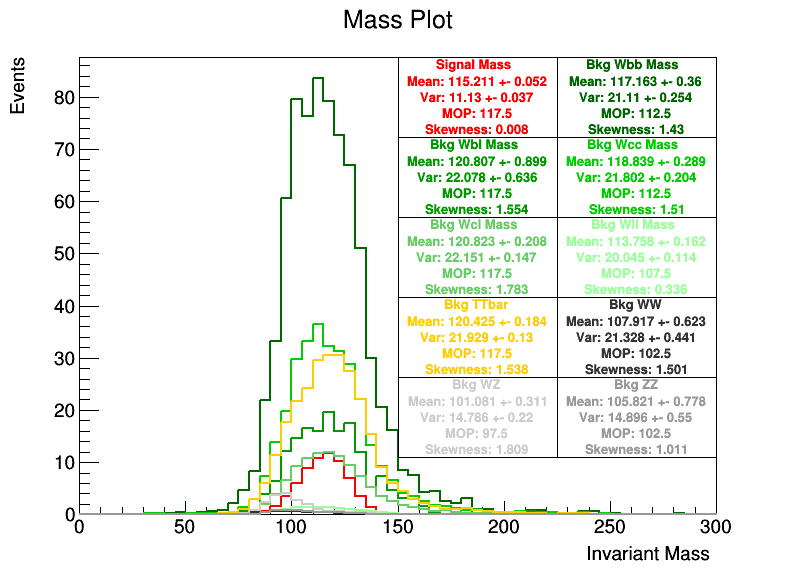

In [16]:
from sklearn.externals import joblib
#Use ROOT in order to create a numpy array with selected variables


processes = "lvbb125,TTbar,Wbb,Wbl,Wll,Wcl,Wcc,WW,WZ,ZZ"
#processes = "lvbb125,ZZ,TTbar"
output_path = "/home/isabella/Workspace/python/PtRelAnalysis/PtRelAnalysis/Results"

data_path = "/home/isabella/Workspace/Adrian2015/Public/WH/output/local/readPaul_1_0_J1Pt45+2BTag+TruthGENWZ+Clean_1_perevent+perjet"

for process in processes.split(","):
    data_input = data_path+"/"+process+".root"
    treeName = "perevent"
    file = ROOT.TFile(data_input,"READ")
    tree = file.Get(treeName)
    #nrEvents = tree.GetEntries()
    nrEvents = 94999

    for (i,entry) in enumerate(tree):
        if nrEvents>0:
            if i>nrEvents:
                break
                
        #=============================================================================
        #=======================EMJESGSCMu========================================
        # variables for EMJESGSCMu j1.     
        E1_EMJESGSCMu = tree.j1_EMJESGSCMu_E
        Phi1_EMJESGSCMu = tree.j1_EMJESGSCMu_Phi
        Eta1_EMJESGSCMu = tree.j1_EMJESGSCMu_Eta
        Pt1_EMJESGSCMu = tree.j1_EMJESGSCMu_Pt
    
        # variables for EMJESGSCMu j2.     
        E2_EMJESGSCMu = tree.j2_EMJESGSCMu_E
        Phi2_EMJESGSCMu = tree.j2_EMJESGSCMu_Phi
        Eta2_EMJESGSCMu = tree.j2_EMJESGSCMu_Eta
        Pt2_EMJESGSCMu = tree.j2_EMJESGSCMu_Pt
    
        # PtRel in EMJESGSCMu
        Theta1_EMJESGSCMu = AuxiliarFunctions.theta(Eta1_EMJESGSCMu)
        Comp1_EMJESGSCMu = AuxiliarFunctions.Componets(E1_EMJESGSCMu,Eta1_EMJESGSCMu,Phi1_EMJESGSCMu,Theta1_EMJESGSCMu)
        norm1_EMJESGSCMu = AuxiliarFunctions.norm(Comp1_EMJESGSCMu)
    
        Theta2_EMJESGSCMu = AuxiliarFunctions.theta(Eta2_EMJESGSCMu)
        Comp2_EMJESGSCMu = AuxiliarFunctions.Componets(E2_EMJESGSCMu,Eta2_EMJESGSCMu,Phi2_EMJESGSCMu,Theta2_EMJESGSCMu)
        norm2_EMJESGCMu = AuxiliarFunctions.norm(Comp2_EMJESGSCMu)
    
        # sum of components.
        Comp3_EMJESGSCMu = AuxiliarFunctions.somaComponents(Comp1_EMJESGSCMu,Comp2_EMJESGSCMu)
        norm3_EMJESGSCMu = AuxiliarFunctions.norm(Comp3_EMJESGSCMu)
        numerador1_EMJESGSCMu = AuxiliarFunctions.numerador(Comp1_EMJESGSCMu,Comp3_EMJESGSCMu)    
        angle1_EMJESGSCMu = AuxiliarFunctions.alpha(numerador1_EMJESGSCMu,norm1_EMJESGSCMu,norm3_EMJESGSCMu)
    
        #compute Relative Pt
        PtRel_j1_EMJESGSCMu = AuxiliarFunctions.PtRelative(E1_EMJESGSCMu,angle1_EMJESGSCMu)
    
        #==========================
        #==========================
    
        # only for EM and j1.
        j1_FracEM3 = tree.j1_FracEM3
        j1_FracTile0 = tree.j1_FracTile0
        j1_TrkWidth = tree.j1_TrkWidth
        j1_EMF = tree.j1_EMF
        j1_JVF = tree.j1_JVF
        j1_NTrk = tree.j1_NTrk 
        j1_SumPtTrk = tree.j1_SumPtTrk
        # only for EM and j2.
        j2_FracEM3 = tree.j2_FracEM3
        j2_FracTile0 = tree.j2_FracTile0
        j2_TrkWidth = tree.j2_TrkWidth
        j2_EMF = tree.j2_EMF
        j2_JVF = tree.j2_JVF
        j2_NTrk = tree.j2_NTrk 
        j2_SumPtTrk = tree.j2_SumPtTrk
    
        
        NNinput = np.array([j1_FracEM3,j1_FracTile0,j1_TrkWidth,j1_EMF,j1_JVF,j1_NTrk,j1_SumPtTrk,Pt1_EMJESGSCMu,Eta1_EMJESGSCMu, Phi1_EMJESGSCMu, E1_EMJESGSCMu, PtRel_j1_EMJESGSCMu,
                            j2_FracEM3,j2_FracTile0,j2_TrkWidth,j2_EMF,j2_JVF,j2_NTrk,j2_SumPtTrk,Pt2_EMJESGSCMu,Eta2_EMJESGSCMu, Phi2_EMJESGSCMu, E2_EMJESGSCMu, PtRel_j1_EMJESGSCMu])
        
        V_NNinput = np.reshape(NNinput, (1,24))
        norm_NNinput = scaler.transform(V_NNinput)
        
        output_NN = classifiers[choose_fold].predict(norm_NNinput)
        #print i ,output_NN
        
        if output_NN[0,1]>0.6:
            
            j1_LV = ROOT.TLorentzVector()
            j2_LV = ROOT.TLorentzVector()
            
            j1_LV.SetPtEtaPhiE(Pt1_EMJESGSCMu,
                           Eta1_EMJESGSCMu, Phi1_EMJESGSCMu,E1_EMJESGSCMu)
            j2_LV.SetPtEtaPhiE(Pt2_EMJESGSCMu,
                           Eta2_EMJESGSCMu, Phi2_EMJESGSCMu,E2_EMJESGSCMu)
            
            dijet_LV = j1_LV + j2_LV
            Mass = dijet_LV.M()
            
            if process == 'lvbb125': 
                
                list_hist_M[0].Fill(Mass,tree.eventWeight)
            if process == 'Wbb':
                list_hist_M[1].Fill(Mass,tree.eventWeight)
            if process == 'Wbl':
                list_hist_M[2].Fill(Mass,tree.eventWeight)
            if process == 'Wcc':
                list_hist_M[3].Fill(Mass,tree.eventWeight)
            if process == 'Wcl':
                list_hist_M[4].Fill(Mass,tree.eventWeight)
            if process == 'Wll':
                list_hist_M[5].Fill(Mass,tree.eventWeight)
            if process == 'TTbar':
                list_hist_M[6].Fill(Mass,tree.eventWeight)
            if process == 'WW':
                list_hist_M[7].Fill(Mass,tree.eventWeight)
            if process == 'WZ':
                list_hist_M[8].Fill(Mass,tree.eventWeight)
            if process == 'ZZ':
                list_hist_M[9].Fill(Mass,tree.eventWeight)
                
clone_list_M = []
for hist in list_hist_M:
    newhist = hist.Clone()
    clone_list_M.append(newhist)
    
#HistogramFunctions.Draw1DHists(list_hist_M,output_path)
HistogramFunctions.DrawList1DHistInCanvas(clone_list_M, "Mass Plot", " Invariant Mass ", "Events", c)        

c

In [25]:
c.Print(output_path+'/plot_junto_encontro_fisica_com_todos_backgrounds.pdf')

In [26]:
ROOT.gROOT.Reset()
ROOT.gStyle.SetOptStat(0)

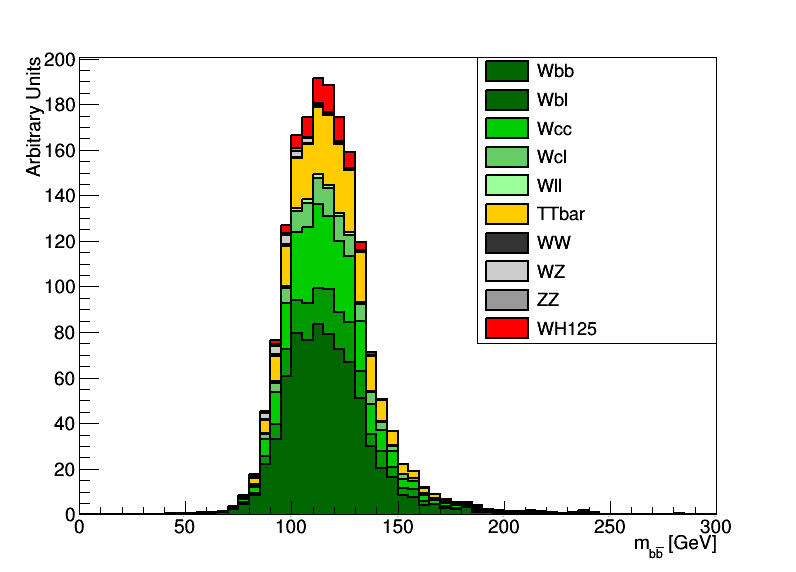

In [22]:
l = rootnotes.canvas("k", (800, 600))
#ROOT.gROOT.Reset()
ROOT.gStyle.SetOptStat(0)

hs = ROOT.THStack('hs',"")
leg = ROOT.TLegend(0.9,0.4,0.6,0.9)

clone_list_M[1].SetFillStyle(200)
clone_list_M[1].SetFillColor(ROOT.kNone)
clone_list_M[1].SetFillColor(list_color[1])
clone_list_M[1].SetLineColor(ROOT.kBlack)
hs.Add(clone_list_M[1])
leg.AddEntry(clone_list_M[1],"Wbb","f")

clone_list_M[2].SetFillStyle(200)
clone_list_M[2].SetFillColor(ROOT.kNone)
clone_list_M[2].SetFillColor(list_color[2])
clone_list_M[2].SetLineColor(ROOT.kBlack)
hs.Add(clone_list_M[2])
leg.AddEntry(clone_list_M[1],"Wbl","f")

clone_list_M[3].SetFillStyle(200)
clone_list_M[3].SetFillColor(ROOT.kNone)
clone_list_M[3].SetFillColor(list_color[3])
clone_list_M[3].SetLineColor(ROOT.kBlack)
hs.Add(clone_list_M[3])
leg.AddEntry(clone_list_M[3],"Wcc","f")

clone_list_M[4].SetFillStyle(200)
clone_list_M[4].SetFillColor(ROOT.kNone)
clone_list_M[4].SetFillColor(list_color[4])
clone_list_M[4].SetLineColor(ROOT.kBlack)
hs.Add(clone_list_M[4])
leg.AddEntry(clone_list_M[4],"Wcl","f")

clone_list_M[5].SetFillStyle(200)
clone_list_M[5].SetFillColor(ROOT.kNone)
clone_list_M[5].SetFillColor(list_color[5])
clone_list_M[5].SetLineColor(ROOT.kBlack)
hs.Add(clone_list_M[5])
leg.AddEntry(clone_list_M[5],"Wll","f")

clone_list_M[6].SetFillStyle(200)
clone_list_M[6].SetFillColor(ROOT.kNone)
clone_list_M[6].SetFillColor(list_color[6])
clone_list_M[6].SetLineColor(ROOT.kBlack)
hs.Add(clone_list_M[6])
leg.AddEntry(clone_list_M[6],"TTbar","f")

clone_list_M[7].SetFillStyle(200)
clone_list_M[7].SetFillColor(ROOT.kNone)
clone_list_M[7].SetFillColor(list_color[7])
clone_list_M[7].SetLineColor(ROOT.kBlack)
hs.Add(clone_list_M[7])
leg.AddEntry(clone_list_M[7],"WW","f")

clone_list_M[8].SetFillStyle(200)
clone_list_M[8].SetFillColor(ROOT.kNone)
clone_list_M[8].SetFillColor(list_color[8])
clone_list_M[8].SetLineColor(ROOT.kBlack)
hs.Add(clone_list_M[8])
leg.AddEntry(clone_list_M[8],"WZ","f")

clone_list_M[9].SetFillStyle(200)
clone_list_M[9].SetFillColor(ROOT.kNone)
clone_list_M[9].SetFillColor(list_color[9])
clone_list_M[9].SetLineColor(ROOT.kBlack)
hs.Add(clone_list_M[9])
leg.AddEntry(clone_list_M[9],"ZZ","f")

clone_list_M[0].SetFillStyle(200)
clone_list_M[0].SetFillColor(ROOT.kNone)
clone_list_M[0].SetFillColor(ROOT.kRed)
clone_list_M[0].SetLineColor(ROOT.kBlack)
hs.Add(clone_list_M[0])
leg.AddEntry(clone_list_M[0],"WH125","f")

hs.Draw();
hs.GetXaxis().SetTitle("m_{b#bar{b}} [GeV]");
hs.GetYaxis().SetTitle("Arbitrary Units");
leg.Draw();
#//hs->GetXaxis()->SetRangeUser(50.,150.);
#gPad.Modified();
#q.Print(output_path+'/stacked_ENFPC.pdf')
l

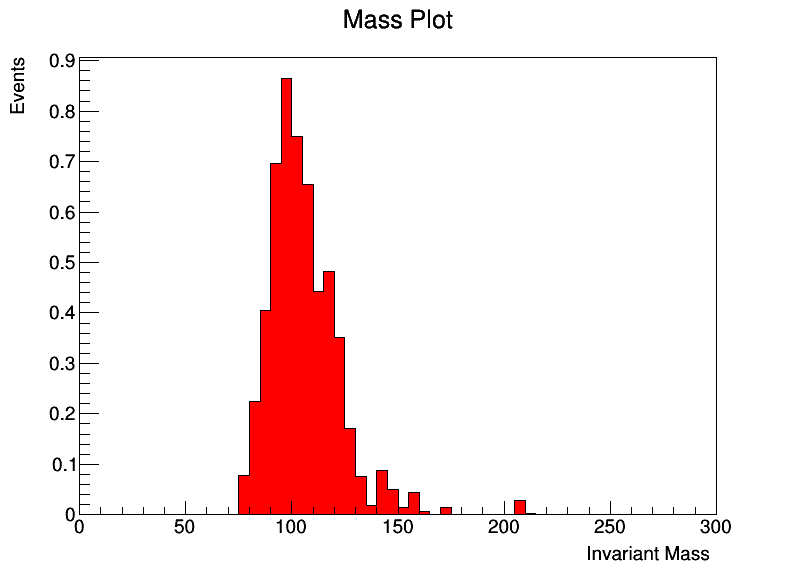

In [35]:
q = rootnotes.canvas("k", (800, 600))
#ROOT.gROOT.Reset()
ROOT.gStyle.SetOptStat(0)
clone_list_M[1].SetFillStyle(200)
clone_list_M[1].SetFillColor(ROOT.kNone)
clone_list_M[1].SetFillColor(ROOT.kRed)
clone_list_M[1].Draw()
q

In [9]:
c.Print(output_path+'/predictPlot.pdf')
print list_hist_M[0].GetEntries()
print list_hist_M[1].GetEntries()

64587.0
4948.0
